**Penjual barang kebutuhan sehari-hari harus menjaga stok tetap tersedia agar pelanggan tidak kecewa karena kehabisan barang. Menjaga jumlah stok yang tepat sangat penting—terlalu sedikit bisa menyebabkan kekurangan, sedangkan terlalu banyak bisa menambah biaya penyimpanan. Dalam proyek ini, kita akan belajar cara menggunakan Machine Learning (ML) untuk memprediksi kebutuhan stok berbagai produk di beberapa toko dengan cara yang sederhana dan efisien**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/train.csv')
display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


,date,store,item,sales
173150,2017-02-15,5.0,10.0,40.0
173151,2017-02-16,5.0,10.0,47.0
173152,2017-02-17,5.0,10.0,47.0
173153,2017-02-18,5.0,10.0,59.0
173154,2017-0,NaN,NaN,NaN


In [3]:
df.shape

(173155, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173155 entries, 0 to 173154
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    173155 non-null  object 
 1   store   173154 non-null  float64
 2   item    173154 non-null  float64
 3   sales   173154 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.3+ MB


In [5]:
df.describe()

,store,item,sales
count,173154.000000,173154.000000,173154.000000
mean,5.369093,5.254513,46.341707
std,2.871848,2.745023,26.712918
min,1.000000,1.000000,0.000000
25%,3.000000,3.000000,24.000000
50%,5.000000,5.000000,42.000000
75%,8.000000,8.000000,63.000000
max,10.000000,10.000000,181.000000


In [6]:
df = df.iloc[:-1]  # Drop the last row with the incomplete date
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1.0,1.0,13.0,2013,1,1
1,2013-01-02,1.0,1.0,11.0,2013,1,2
2,2013-01-03,1.0,1.0,14.0,2013,1,3
3,2013-01-04,1.0,1.0,13.0,2013,1,4
4,2013-01-05,1.0,1.0,10.0,2013,1,5


In [7]:
from datetime import date
import holidays

def is_holiday(x, holiday_list):
  return 1 if x in holiday_list else 0

# Get the range of years in the dataframe
min_year = df['year'].min()
max_year = df['year'].max()

# Generate holidays for the range of years
india_holidays = holidays.country_holidays('IN', years=range(min_year, max_year + 1))

# Convert date column to datetime objects to match the format in the holidays list
df['date'] = pd.to_datetime(df['date'])

# Apply the is_holiday function using the generated holidays list
df['holidays'] = df['date'].apply(lambda x: is_holiday(x, india_holidays))

df.head()

,date,store,item,sales,year,month,day,holidays
0,2013-01-01,1.0,1.0,13.0,2013,1,1,0
1,2013-01-02,1.0,1.0,11.0,2013,1,2,0
2,2013-01-03,1.0,1.0,14.0,2013,1,3,0
3,2013-01-04,1.0,1.0,13.0,2013,1,4,0
4,2013-01-05,1.0,1.0,10.0,2013,1,5,0


In [8]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,holidays,m1,m2
0,2013-01-01,1.0,1.0,13.0,2013,1,1,0,0.5,0.866025
1,2013-01-02,1.0,1.0,11.0,2013,1,2,0,0.5,0.866025
2,2013-01-03,1.0,1.0,14.0,2013,1,3,0,0.5,0.866025
3,2013-01-04,1.0,1.0,13.0,2013,1,4,0,0.5,0.866025
4,2013-01-05,1.0,1.0,10.0,2013,1,5,0,0.5,0.866025


In [9]:
from datetime import datetime

def which_day(year, month, day):

	d = datetime(year,month,day)
	return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
													x['month'],
													x['day']),
								axis=1)
df.head()


,date,store,item,sales,year,month,day,holidays,m1,m2,weekday
0,2013-01-01,1.0,1.0,13.0,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1.0,1.0,11.0,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1.0,1.0,14.0,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1.0,1.0,13.0,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1.0,1.0,10.0,2013,1,5,0,0.5,0.866025,5


In [10]:
df.drop('date', axis=1, inplace=True)

In [11]:
df['store'].nunique(), df['item'].nunique()

(10, 10)

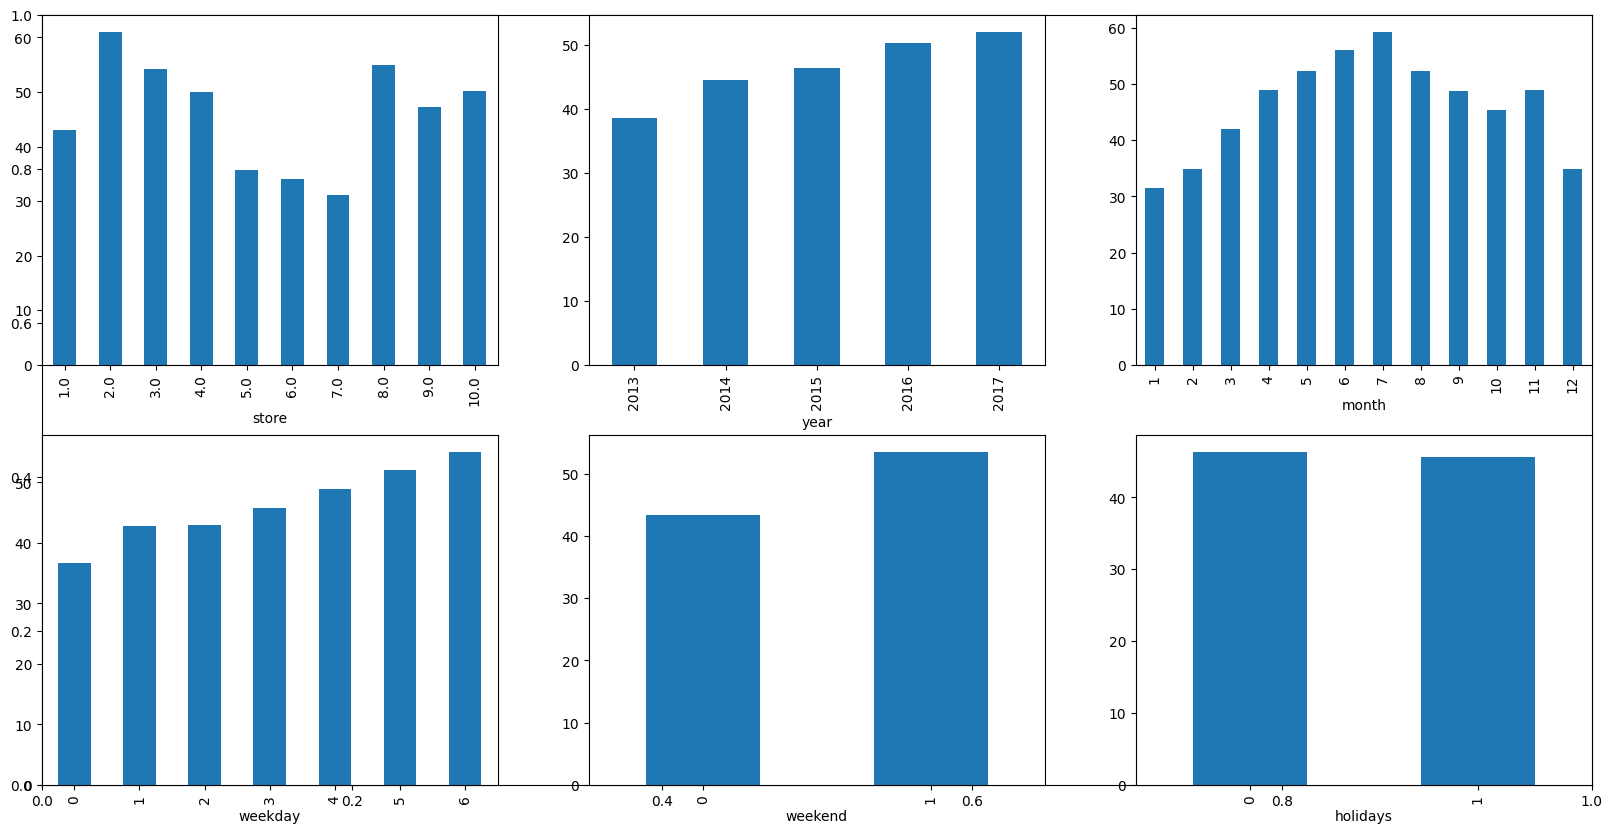

In [12]:
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

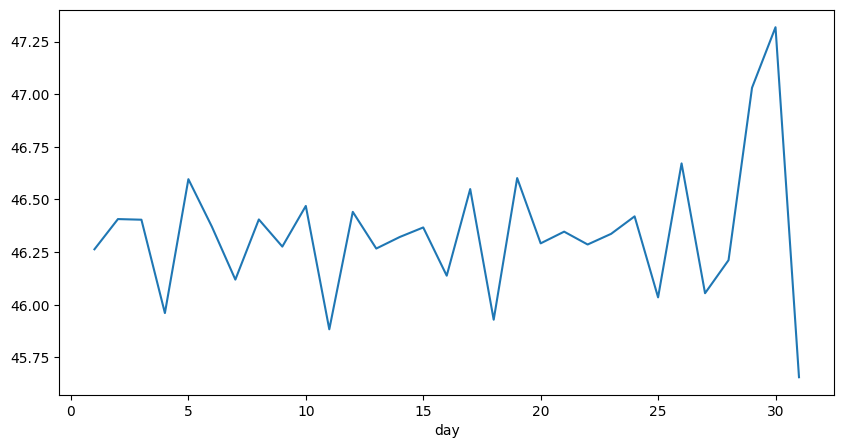

In [13]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

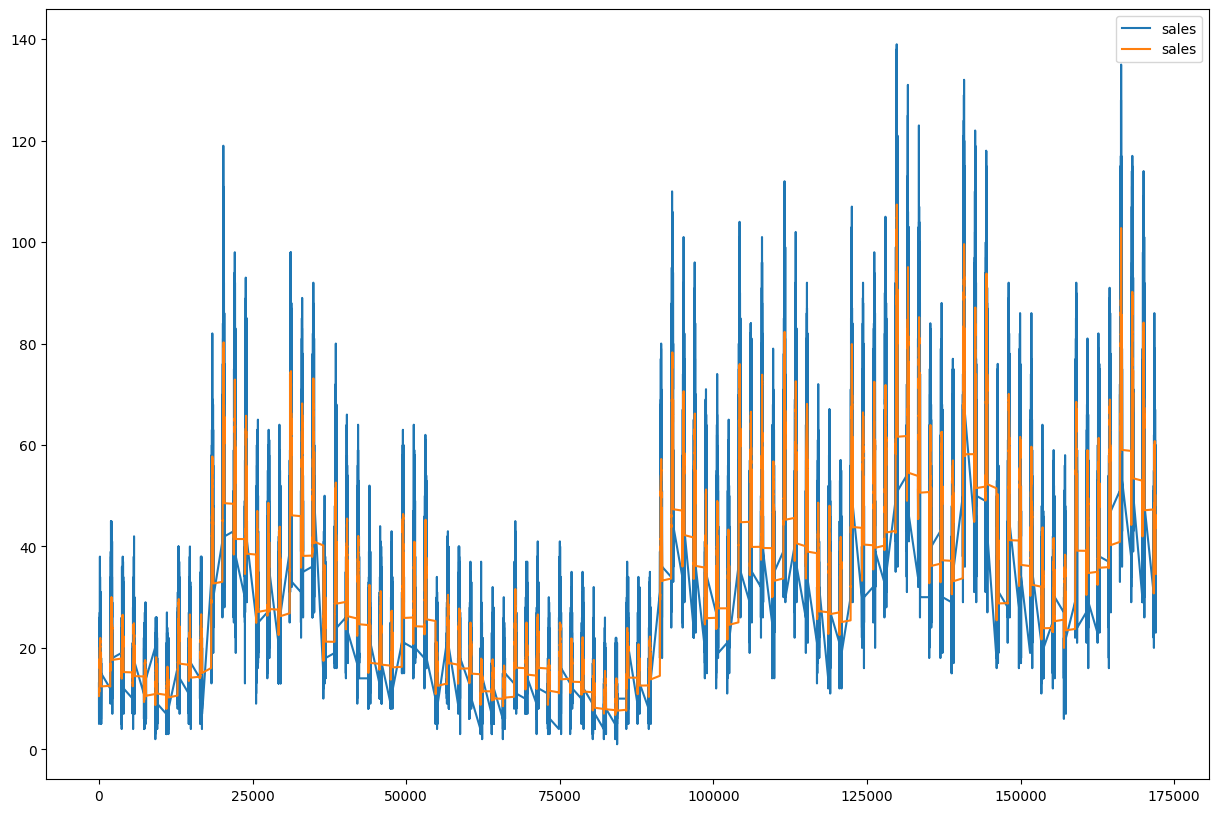

In [14]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

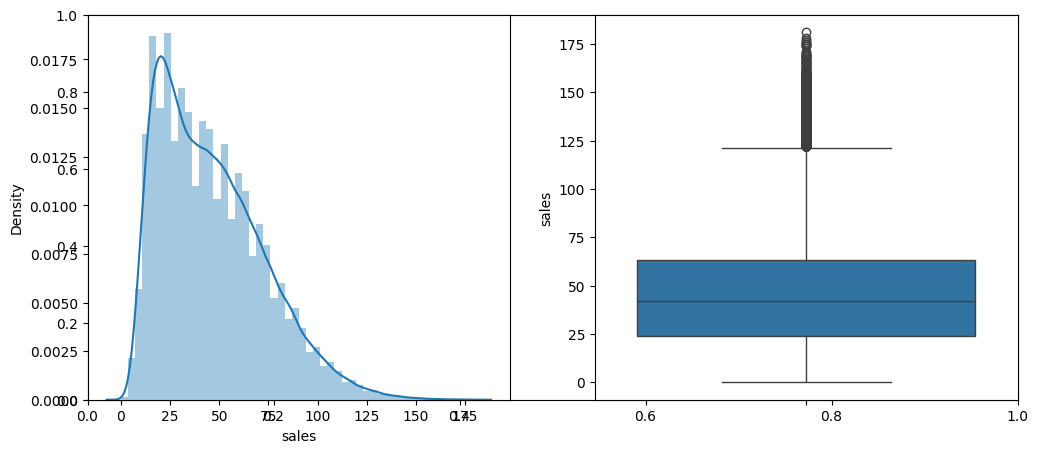

In [15]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

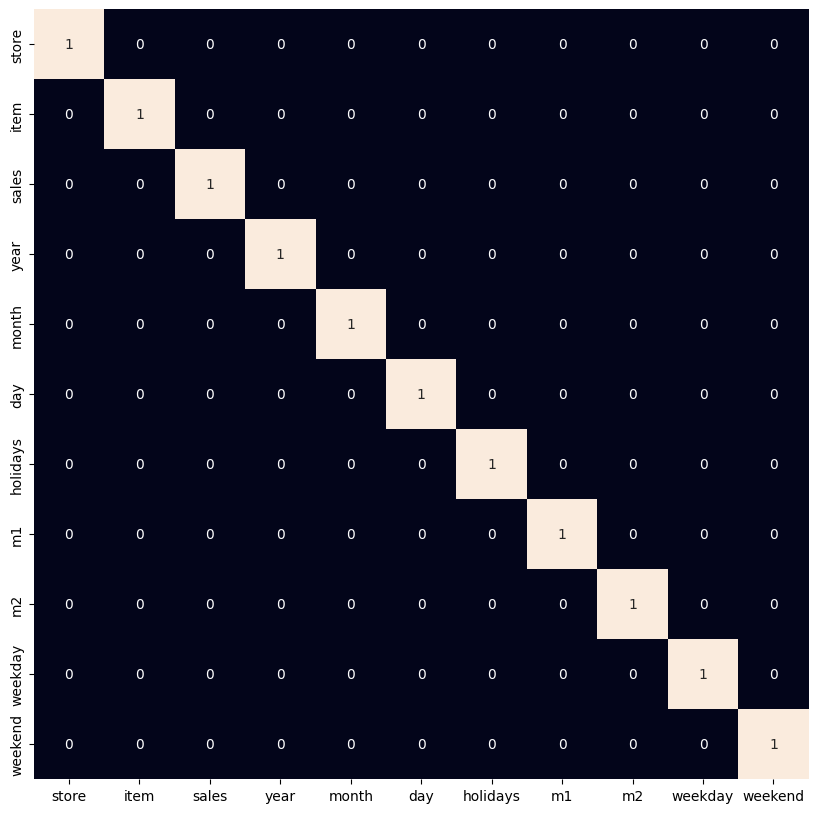

In [16]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()

In [17]:
df = df[df['sales']<140]

In [18]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
												test_size = 0.05,
												random_state=22)
X_train.shape, X_val.shape

((164109, 9), (8638, 9))

In [19]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [20]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
	models[i].fit(X_train, Y_train)

	print(f'{models[i]} : ')

	train_preds = models[i].predict(X_train)
	print('Training Error : ', mae(Y_train, train_preds))

	val_preds = models[i].predict(X_val)
	print('Validation Error : ', mae(Y_val, val_preds))
	print()

LinearRegression() : 
Training Error :  16.971816833331385
Validation Error :  16.79596176535415

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  5.930093188398827
Validation Error :  5.993470890705827

Lasso() : 
Training Error :  17.083963360051836
Validation Error :  16.881674